In [1]:
%load_ext autoreload
%autoreload 2

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix, generate_laser_D

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

In [2]:
script_dir = Path().parent.absolute()

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [3]:
Js_g = [1] # J values to be included

parity = lambda J: (-1)**J

# generate a list of approximate ground states
ground_states_approx = generate_coupled_ground_states(Js_g, electronic_state = 'X',
                                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                                       I_F = 1/2)
ground_states_approx = [1*state for state in ground_states_approx]

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [4]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

H_X_uc = generate_X_hamiltonian_function(H_X_uc)

In [5]:
# generate coupled basis states
Jmin = 0
Jmax = 4
QN_X = generate_coupled_ground_states(ni_range(Jmin, Jmax + 1), electronic_state = 'X',
                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                       I_F = 1/2)

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

# diagonalize the Hamiltonian
H_X_diag, V, V_ref_X = generate_diagonalized_hamiltonian(H_X, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation. Only need the states that are coupled to J = 1 in the X-state by the laser.

In [6]:
I_F = 1/2
I_Tl = 1/2

# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [1,1]
F1_excited = [1/2,1/2]
F_excited = [0,1]

# generate a list of excited states. The exact excited states are determined within the main
# simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = 1, Omega = 1)
                  for J,F1,F in zip(J_excited, F1_excited, F_excited)
                  for mF in ni_range(-F, F+1)
                 ]

Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [7]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [8]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [9]:
H_B = generate_B_hamiltonian_function(H_B)*2*np.pi

# generate coupled basis states
Jmin = 1
Jmax = 3
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]


H_B_diag, V, V_ref_B = generate_diagonalized_hamiltonian(H_B, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [10]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

In [11]:
_ = np.abs(np.diff(np.diag(H_B_red)/(1e6*2*np.pi)).real)
_[_ > 1]

array([563.67820342])

In [12]:
_ = np.abs(np.diff(np.diag(H_X_red)/(1e3*2*np.pi)).real)
_[_ > 1]

array([ 22.24048594, 175.95410925,  14.54203338])

## Laser coupling
### Calculating transition 1; Q(1), F$_1$'=1/2, F'=0

In [13]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
excited_states_laser_approx = [1*CoupledBasisState(
                                F=0,mF=0,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
                                )
                            ]

In [14]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=1,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=0,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = 1, Omega = 1)

In [15]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [16]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0

In [17]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(-0.29025602182508786+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [18]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

### Calculating transition 1; Q(1), F$_1$'=1/2, F'=1

In [19]:
#Define ground states for laser driven transition
Js = [1]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
excited_states_laser_approx = [1*CoupledBasisState(
                                F=1,mF=mF,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
                                )
                               for mF in range(-1,1+1)
                            ]

In [20]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=2,mF=0,I1=1/2,I2=1/2,electronic_state='X', P = -1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=1/2,F=1,mF=0,I1=1/2,I2=1/2, electronic_state='B', P = 1, Omega = 1)

In [21]:
ground_states_laser_2 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_2 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_2 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_2, 
                                    excited_states_laser_2, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_2 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_2, 
                                    excited_states_laser_2, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [22]:
# set small values to zero
H_laser_z_2[np.abs(H_laser_z_2) < 1e-3*np.max(np.abs(H_laser_z_2))] = 0
H_laser_x_2[np.abs(H_laser_x_2) < 1e-3*np.max(np.abs(H_laser_z_2))] = 0

In [23]:
ground_main_2 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_2 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_2 = ED_ME_mixed_state(
                        excited_main_2, ground_main_2, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_2 = QN.index(ground_main_2)
excited_main_idx_2 = QN.index(excited_main_2)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_2.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_2.print_state()

(-0.29025602182508786+0j)
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>
----------------------------------------------------------------------------------------------------
+0.9996+0.0000j x |B, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 1>


In [24]:
D2 = generate_laser_D(H_rot, QN, ground_main_2, excited_main_2, excited_states_laser_2, Δ = 0)

## Total Hamiltonian

In [25]:
H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx_1,ground_main_idx_1]
H_rot = H_rot + D1 + D2

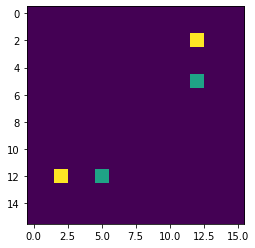

In [26]:
plt.imshow(H_laser_z_1.real)

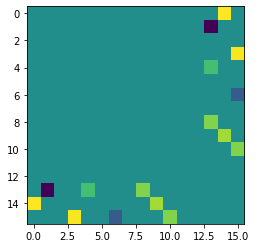

In [27]:
plt.imshow(H_laser_z_2.real)

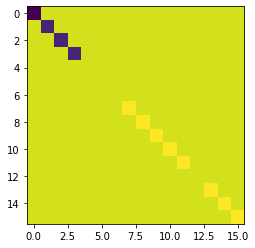

In [28]:
plt.imshow(H_rot.real)

In [29]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 15.69it/s]

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 12.82it/s]


In [30]:
t = Symbol("t", real = True)
Px1 = Function("Px1")(t) # Polarization switching function for x
Pz1 = Function("Pz1")(t) # Polarization switching function for z
Px2 = Function("Px2")(t) # Polarization switching function for x
Pz2 = Function("Pz2")(t) # Polarization switching function for z

laser_fields = [(H_laser_z_1*Pz1, ME_main_1), (H_laser_x_1*Px1, ME_main_1), 
                (H_laser_z_2*Pz2, ME_main_2), (H_laser_x_2*Px2, ME_main_2)]
detunings = [[QN.index(excited_states[0])], [QN.index(excited_states[idx]) for idx in [1,2,3]]]

In [31]:
n_states = H_laser_z_1.shape[0]
excited_state_indices = [QN.index(exc_state) for exc_state in excited_states]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [32]:
H_symbolic

Matrix([
[            -1245272.14598083,                            0,                             0,                             0,                             0,                             0,                             0,                           0,                             0,                             0,                             0,                             0,                            0,  0.487104536814559*Ω4*Px2(t), -0.688943961004228*Ω3*Pz2(t), -0.487209355797023*Ω4*Px2(t)],
[                            0,            -1105531.05151367,                             0,                             0,                             0,                             0,                             0,                           0,                             0,                             0,                             0,                             0,  0.607920432419512*Ω2*Px1(t),  0.674428203801002*Ω3*Pz2(t),  0.476889169493474*Ω4*Px2(t),                            0],
[        

In [33]:
H_symbolic = H_symbolic.subs(Ωs[1][0],Ωs[0][0]).subs(Ωs[1][1],Ωs[0][1])
H_symbolic = H_symbolic.subs(Ωs[2][0],Ωs[1][0]).subs(Ωs[2][1],Ωs[1][1])
H_symbolic = H_symbolic.subs(Ωs[3][0],Ωs[1][0]).subs(Ωs[3][1],Ωs[1][1])

In [34]:
system = generate_system_of_equations(H_symbolic, C_array, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:14<00:00,  2.05it/s]


In [35]:
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [36]:
# import julia
# julia.install()

In [37]:
from julia import Main

In [38]:
Main.eval("""
using Distributed
using BenchmarkTools
addprocs(6)

@everywhere begin
    using LinearAlgebra
    using Trapz
    using DifferentialEquations
    include("utils/general_ode_functions.jl")
end
""")

In [39]:
if Main.eval("nprocs()") > 6:
    procs = Main.eval("procs()")
    procs = procs[procs > 6]
    Main.eval(f"rmprocs({procs})")

In [40]:
# Px = Main.eval("[sine_wave(ti, νp1, 4.71238898038469) for ti = range(0,1/νp1,length=101)]")
# Pz = Main.eval("[sine_wave(ti, νp1, 1.5707963267948966) for ti = range(0,1/νp1,length=101)]")
# normalization = np.sqrt(Px**2+Pz**2)
# plt.plot(np.array([Px,Pz]).T/normalization[:,np.newaxis])

In [41]:
Main.eval("procs()")
# Main.eval("rmprocs(7,8,9,10,11,12,13)")

array([1, 2, 3, 4, 5, 6], dtype=int64)

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [42]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩ1 = p[1]
\t\tνp1 = p[2]
\t\tΔ1 = p[3]
\t\tΩ2 = p[4]
\t\tνp2 = p[5]
\t\tΔ2 = p[6]
\t\tΩ1ᶜ = conj(Ω1)
\t\tΩ2ᶜ = conj(Ω2)
\t\tPx1 = sine_wave(t, νp1, 4.71238898038469)
\t\tPz1 = sine_wave(t, νp1, 1.5707963267948966)
\t\tPx2 = sine_wave(t, νp2, 1.5707963267948966)
\t\tPz2 = sine_wave(t, νp2, 4.71238898038469)
\t\tnorm1 = sqrt(Px1^2+Pz1^2)
\t\tnorm2 = sqrt(Px2^2+Pz2^2)
\t\tPx1 /= norm1
\t\tPz1 /= norm1
\t\tPx2 /= norm2
\t\tPz2 /= norm2
"""

In [43]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω1 = p[1]
		νp1 = p[2]
		Δ1 = p[3]
		Ω2 = p[4]
		νp2 = p[5]
		Δ2 = p[6]
		Ω1ᶜ = conj(Ω1)
		Ω2ᶜ = conj(Ω2)
		Px1 = sine_wave(t, νp1, 4.71238898038469)
		Pz1 = sine_wave(t, νp1, 1.5707963267948966)
		Px2 = sine_wave(t, νp2, 1.5707963267948966)
		Pz2 = sine_wave(t, νp2, 4.71238898038469)
		norm1 = sqrt(Px1^2+Pz1^2)
		norm2 = sqrt(Px2^2+Pz2^2)
		Px1 /= norm1
		Pz1 /= norm1
		Px2 /= norm2
		Pz2 /= norm2



In [44]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [45]:
with open('ode_amherst_cyling.jl', 'w', encoding='utf8') as f:
    f.write(ode_fun)

In [46]:
# reading from file
with open('ode_amherst_cyling.jl', 'r', encoding='utf8') as f:
    ode_fun = f.read()

In [47]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

In [48]:
ρ_ini = np.zeros([n_states, n_states], dtype = complex)
np.fill_diagonal(ρ_ini[:n_states-4, :n_states-4], 1/(n_states-4))

In [49]:
Γ = 2*np.pi * 1.56e6
Ω1 = 0.1*Γ
Ω2 = 0.1*Γ
ωp1 = 2*np.pi*2e6 # 2 MHz
ωp2 = 2*np.pi*2e6 # 2 MHz
Δ1 = 0
Δ2 = 0
ωp1 = 0*np.pi*2e6
ωp2 = 0*np.pi*2e6

νp1 = ωp1/(2*np.pi)
νp2 = ωp2/(2*np.pi)

Main.Γ = Γ
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Δ1 = Δ1
Main.Ω2 = Ω2
Main.νp2 = νp2
Main.Δ2 = Δ2

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    Ω1 = Γ
    Ω2 = Γ
    Δ1 = 0
    Δ2 = 0
    νp1 = 1e6
    νp2 = 1e6
    p = [Ω1, νp1, Δ1, Ω2, νp2, Δ2]
end
""")

In [50]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
@btime Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 6.22 s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [51]:
Main.eval("""
tspan = (0.0f0, 2*25.4/1e3 / 184)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [52]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-9, reltol = 1e-6, dt = 1e-9)
tmp = 0
""");

Wall time: 4.38 s


0

In [53]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t") * 1e6

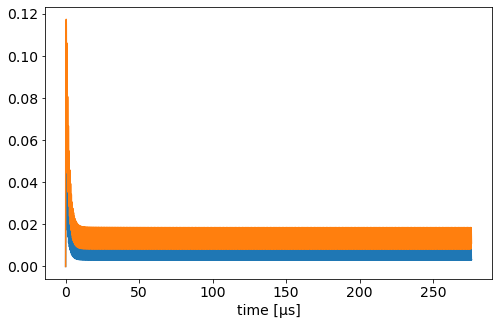

In [54]:
exc_F0 = pop_results[-4,:]
exc_F1 = np.sum(pop_results[-3:,:], axis = 0)

fig, ax = plt.subplots(figsize = (8,5))
ax.plot(t_array, exc_F0)
ax.plot(t_array, exc_F1)

ax.set_xlabel('time [μs]')

set_fontsize(ax, 14)

In [55]:
np.trapz(exc_F0+exc_F1, t_array/1e6)*Γ

51.199876650961365

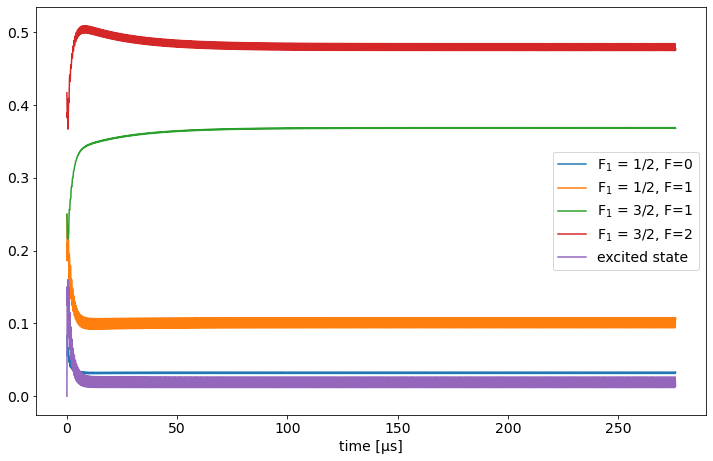

In [56]:
fig, ax = plt.subplots(figsize = (12,7.5))
ax.plot(t_array, pop_results[0,:], label = r'F$_1$ = 1/2, F=0')
ax.plot(t_array, np.sum(pop_results[1:4,:], axis = 0), label = r'F$_1$ = 1/2, F=1')
ax.plot(t_array, np.sum(pop_results[4:7,:], axis = 0), label = r'F$_1$ = 3/2, F=1')
ax.plot(t_array, np.sum(pop_results[7:12,:], axis = 0), label = r'F$_1$ = 3/2, F=2')
ax.plot(t_array, np.sum(pop_results[-4:], axis = 0), label = 'excited state')

ax.set_xlabel('time [μs]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

In [57]:
for s in QN:
    s.print_state()

+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+0.9961-0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000-0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000-0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2

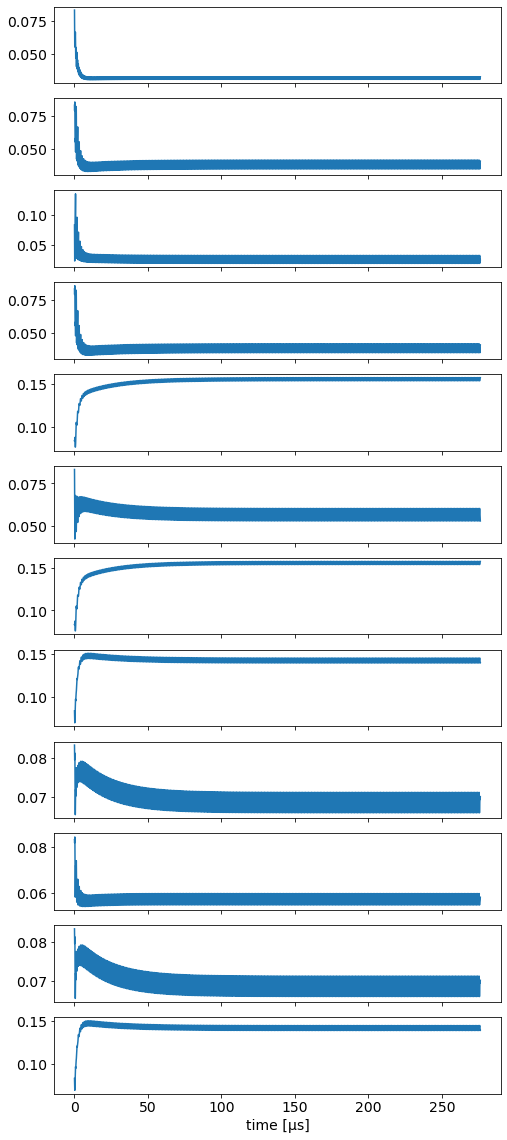

In [58]:
fig, axes = plt.subplots(figsize = (8,20), nrows = 12, sharex = True)
for idx, pop in enumerate(pop_results[:-4]):
    axes[idx].plot(t_array, pop)

axes[idx].set_xlabel('time [μs]')
for ax in axes:
    set_fontsize(ax, 14)

### Parameter scan for polarization switching frequency

In [59]:
Main.eval("""
@everywhere params = [val*Γ/(2pi) for val in 0:5/401:5]""")
# Main.params = Main.νs

In [60]:
# defining a progress bar to keep track of the ODE ensemble solver progress
# Main.eval("using ProgressMeter")
# Main.eval('const pbar = Progress(50, 1, "ODE Solving ", 50)')

In [61]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[13:end])) for j in 1:size(sol.u)[1]]), false
end""")

In [62]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [63]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[Ω1; params[i]; Δ1; Ω2; params[i]; Δ2])
end
""")

In [64]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [65]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

45.6128058

In [66]:
results_νs = Main.eval("sim.u")

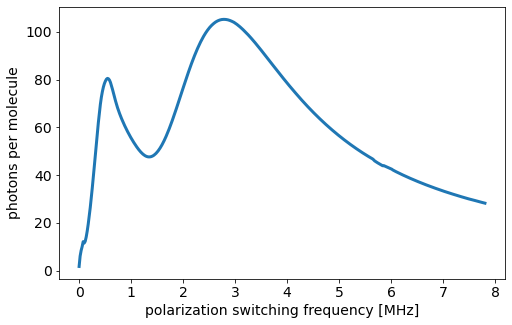

In [67]:
νs = Main.params
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(νs/1e6, results_νs*Γ, lw = 3)
ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)

In [68]:
νs[np.argmax(results_νs)]

2781546.134663342

### Parameter scan for Ω

In [69]:
Main.eval("@everywhere params = [val*Γ for val in 0:3/101:3]")

In [70]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval("""
@everywhere function output_func(sol,i)
    # next!(pbar)
    return trapz(sol.t, [real(sum(diag(sol.u[j])[13:end])) for j in 1:size(sol.u)[1]]), false
end""")

In [71]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [72]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[params[i]; 2769000.0; Δ1; params[i]; 2769000.0; Δ2])
end
""")

In [73]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""")

<PyCall.jlwrap EnsembleProblem{ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, typeof(prob_func), typeof(output_func), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}(ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}(ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, N

In [74]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

10.5836676

In [75]:
results_Ωs = Main.eval("sim.u")

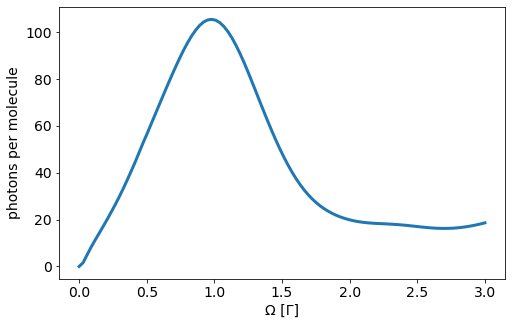

In [76]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/Γ, results_Ωs*Γ, lw = 3)
ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)

### Parameter scan for Δ

In [97]:
if Main.eval("nprocs()") > 6:
    procs = Main.eval("procs()")
    procs = procs[procs > 6]
    Main.eval(f"rmprocs({procs})")

In [98]:
Main.eval("@everywhere params = [val*2pi*1e6 for val in range(-25,25,length=101)]")

In [99]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [105]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[0.8Γ; 0.0; params[i]; 0; 2769000.0; params[i]])
end
""")

In [106]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""");

In [107]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

8.3824473

In [108]:
results_Δs = Main.eval("sim.u")

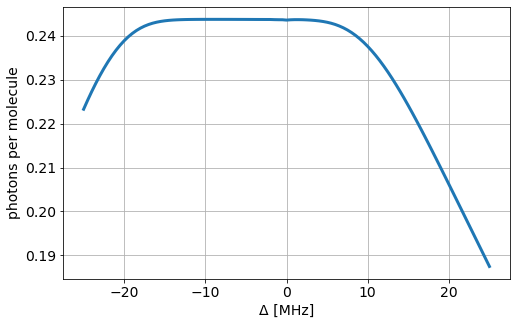

In [109]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/(2*np.pi*1e6), results_Δs*Γ, lw = 3)
ax.set_xlabel('Δ [MHz]')
ax.set_ylabel('photons per molecule')
ax.grid(True)
set_fontsize(ax, 14)

### 2D parameter scan

In [85]:
Main.Ωs = np.linspace(0.1,3,101)*Γ
Main.νs = np.linspace(0.1,5,101)*1e6
params = np.array(np.meshgrid(Main.Ωs, Main.νs)).T.reshape(-1,2)
Main.params = params
Main.eval("@eval @everywhere params = $params")

In [86]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[params[i,1]; params[i,2]; Δ1; params[i,1]; params[i,2]; Δ2])
end
""")

# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func); 
""")

<PyCall.jlwrap EnsembleProblem{ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, typeof(prob_func), typeof(output_func), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}(ODEProblem{Matrix{ComplexF64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}(ODEFunction{true, typeof(Lindblad_rhs!), UniformScaling{Bool}, Nothing, Nothing, N

In [87]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

617.5259765

In [88]:
results_scan = Main.eval("sim.u")

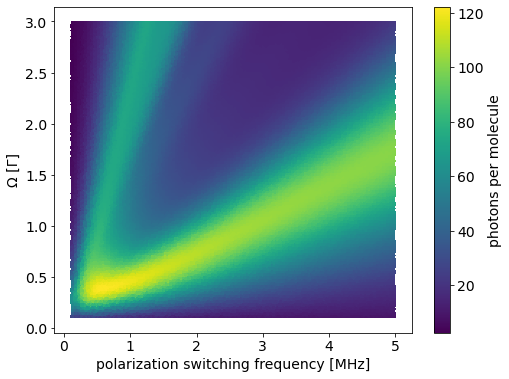

In [89]:
x = params[:,1].real/1e6
y = params[:,0].real/Γ
z = results_scan*Γ

fig, ax = plt.subplots(figsize = (8,6))
# cs = ax.tricontourf(x,y,z, levels = 15)
cs = ax.tripcolor(x,y,z)

# ax.set_xscale('log')

ax.set_xlabel('polarization switching frequency [MHz]')
ax.set_ylabel('Ω [Γ]')

cbar = fig.colorbar(cs)
cbar.ax.set_ylabel('photons per molecule')

set_fontsize(ax, 14)
set_fontsize(cbar.ax, 14)

In [90]:
det1 = np.zeros(D1.shape, dtype = int)
det1[np.nonzero(D1)] = 1

det2 = np.zeros(D2.shape, dtype = int)
det2[np.nonzero(D2)] = 1

In [91]:
dat = np.vstack([x,y,z]).T
with h5py.File('amherst_cycling_constant_fields.hdf5', 'w') as f:
    grp = f.create_group('scan Ω and ν')
    grp.attrs['fixed parameters'] = f"Δ1 = 0, Δ2 = 0, Γ = {Γ} [2pi Hz]"
    grp.attrs['integration time'] = 0,300e-6
    grp.attrs['ode function'] = ode_fun
    dset = grp.create_dataset('results', data = dat)
    dset.attrs["columns"] = "Ω [Γ], ν [MHz], integrated excited state population*Γ = photons per molecule"
    
    grp.create_dataset('ρ initial', data = ρ_ini)
    
    hg = grp.create_group('hamiltonian')
    hg.create_dataset('rotating', data = H_rot)
    lg = hg.create_group('laser hamiltonians')
    ldset = lg.create_dataset('laser 1 x', data = H_laser_x_1)
    ldset.attrs['ME_main'] = laser_fields[0][1]
    ldset = lg.create_dataset('laser 1 z', data = H_laser_z_1)
    ldset.attrs['ME_main'] = laser_fields[0][1]
    ldset = lg.create_dataset('laser 2 x', data = H_laser_x_2)
    ldset.attrs['ME_main'] = laser_fields[2][1]
    ldset = lg.create_dataset('laser 2 z', data = H_laser_z_2)
    ldset.attrs['ME_main'] = laser_fields[2][1]
    
    dg = hg.create_group('detunings')
    dg.create_dataset('detunings laser 1', data = det1)
    dg.create_dataset('detunings laser 2', data = det2)
    
    hg.create_dataset('collapse matrices', data = C_array)

### Add detunings

In [92]:
Main.Ωs = np.linspace(0.1,3,25)*Γ
Main.νs = np.linspace(0.1,5,25)*1e6
Main.Δs = np.linspace(-25,25,25)*1e6*2*np.pi
params = np.array(np.meshgrid(Main.Ωs, Main.νs, Main.Δs)).T.reshape(-1,3)

   22.24 kHz
   -0.00 kHz
   -0.00 kHz
  175.95 kHz
    0.00 kHz
    0.00 kHz
   14.54 kHz
   -0.00 kHz
   -0.00 kHz
   -0.00 kHz
   -0.00 kHz


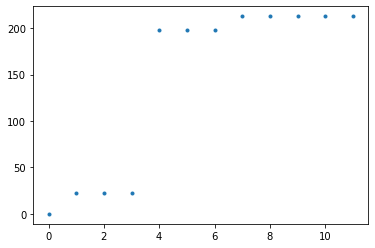

In [93]:
_m = np.diag(H_X_red.real)/(2*np.pi*1e3)
plt.plot(_m - _m[0], '.')
for val in np.diff(_m):
    print(f"{val:>8.2f} kHz")

  563.68 MHz
    0.00 MHz
    0.00 MHz


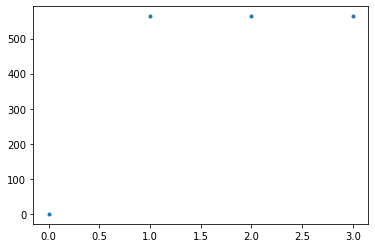

In [94]:
_m = np.diag(H_B_red.real)/(2*np.pi*1e6)
plt.plot(_m - _m[0], '.')
for val in np.diff(_m):
    print(f"{val:>8.2f} MHz")

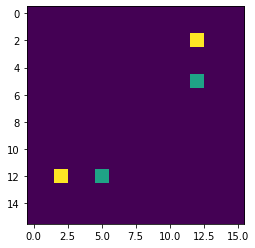

In [110]:
plt.imshow(H_laser_z_1.real)

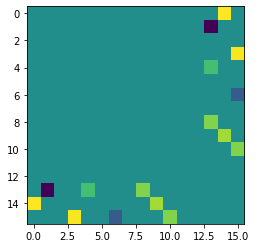

In [116]:
plt.imshow(H_laser_z_2.real)

In [111]:
np.nonzero(H_laser_z_1)

(array([ 2,  5, 12, 12], dtype=int64), array([12, 12,  2,  5], dtype=int64))

In [112]:
H_laser_z_1[np.nonzero(H_laser_z_1)]

array([0.49908393+0.j, 0.29025602+0.j, 0.49908393+0.j, 0.29025602+0.j])

In [114]:
np.diag(H_rot)

array([-1.24527215e+06+0.j, -1.10553105e+06+0.j, -1.10554175e+06+0.j,
       -1.10555245e+06+0.j, -1.78543091e-01+0.j,  0.00000000e+00+0.j,
        1.79122925e-01+0.j,  9.13704696e+04+0.j,  9.13601686e+04+0.j,
        9.13498672e+04+0.j,  9.13395653e+04+0.j,  9.13292628e+04+0.j,
        0.00000000e+00+0.j,  9.13435840e+04+0.j,  9.13498672e+04+0.j,
        9.13561504e+04+0.j])

In [115]:
np.nonzero(H_laser_z_2)

(array([ 0,  1,  3,  4,  6,  8,  9, 10, 13, 13, 13, 14, 14, 15, 15, 15],
       dtype=int64),
 array([14, 13, 15, 13, 15, 13, 14, 15,  1,  4,  8,  0,  9,  3,  6, 10],
       dtype=int64))

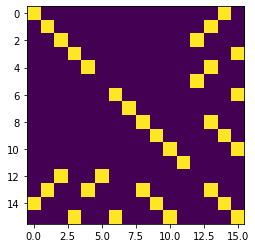

In [124]:
ind = np.nonzero(H_rot+H_laser_z_1+H_laser_z_2)
tmp = np.zeros(H_rot.shape)
tmp[ind] = 1
plt.imshow(tmp)

In [172]:
import numpy as np
from sympy import Symbol
from optical_bloch.utils.general import flatten
from optical_bloch import Hamiltonian, Dissipator, BlochEquations

ωa = Symbol('ω_a', real = True)
ωb = Symbol('ω_b', real = True)
ωc = Symbol('ω_c', real = True)
ωd = Symbol('ω_d', real = True)
ωE1 = Symbol('ω_E1', real = True)
ωE2 = Symbol('ω_E2', real = True)

ω_F1mF0 = Symbol('ω_F1mF0', real = True)
Ω_F1mF0 = Symbol('Ω_F1mF0', real = True)
ω_F0mF0  = Symbol('ω_F0mF0 ', real = True)
Ω_F0mF0 = Symbol('Ω_F0mF0', real = True)

indices = [(0,14), (1,13), (3,15), (4,13), (6,15), (8,13), (9,14), (10,15)]
other_couplings = [(ind1, ind2, Symbol(f'Ω{ind1}{ind2}', real = True), Symbol(f'ω{ind1}{ind2}', real = True)) for ind1, ind2 in indices]

Δ1 = Symbol('Δ1', real = True)
Δ2 = Symbol('Δ2', real = True)

ham = Hamiltonian(16)
ham.addEnergies([ωa, ωb, ωb, ωb, ωc, ωc, ωc, ωd, ωd, ωd, ωd, ωd, ωE1, ωE2, ωE2, ωE2])
ham.addCoupling(2,12,Ω_F0mF0,ω_F0mF0)
ham.addCoupling(5,12,Ω_F1mF0,ω_F1mF0)
for ind1, ind2, Ω, ω in other_couplings:
    ham.addCoupling(ind1,ind2,Ω,ω)
ham.eqnTransform()
ham.defineZero(ωE2)
ham.defineStateDetuning(2,12,Δ1)
ham.defineStateDetuning(5,12,Δ1)
for ind1, ind2 in indices:
    ham.defineStateDetuning(ind1, ind2,Δ2)

In [173]:
ham.transformed

Matrix([
[-1.0*Δ2,       0,                  0,       0,       0,                  0,       0,   0,       0,       0,        0,   0,          0,       0, -Ω014/2,        0],
[      0, -1.0*Δ2,                  0,       0,       0,                  0,       0,   0,       0,       0,        0,   0,          0, -Ω113/2,       0,        0],
[      0,       0, -1.0*Δ1 + 1.0*ω_E1,       0,       0,                  0,       0,   0,       0,       0,        0,   0, -Ω_F0mF0/2,       0,       0,        0],
[      0,       0,                  0, -1.0*Δ2,       0,                  0,       0,   0,       0,       0,        0,   0,          0,       0,       0,  -Ω315/2],
[      0,       0,                  0,       0, -1.0*Δ2,                  0,       0,   0,       0,       0,        0,   0,          0, -Ω413/2,       0,        0],
[      0,       0,                  0,       0,       0, -1.0*Δ1 + 1.0*ω_E1,       0,   0,       0,       0,        0,   0, -Ω_F1mF0/2,       0,       0,        0],
[

In [175]:
test = sympy.diag(*ham.transformed.diagonal())
test = test.subs(ωa, 0).subs(ωb, 22e3*2*np.pi).subs(ωc, 2*np.pi*(22+176)*1e3).subs(ωd, 2*np.pi*1e3*(14.5+176+22.2))
test

Matrix([
[-1.0*Δ2,       0,                  0,       0,       0,                  0,       0,               0,       0,       0,       0,               0,    0, 0, 0, 0],
[      0, -1.0*Δ2,                  0,       0,       0,                  0,       0,               0,       0,       0,       0,               0,    0, 0, 0, 0],
[      0,       0, -1.0*Δ1 + 1.0*ω_E1,       0,       0,                  0,       0,               0,       0,       0,       0,               0,    0, 0, 0, 0],
[      0,       0,                  0, -1.0*Δ2,       0,                  0,       0,               0,       0,       0,       0,               0,    0, 0, 0, 0],
[      0,       0,                  0,       0, -1.0*Δ2,                  0,       0,               0,       0,       0,       0,               0,    0, 0, 0, 0],
[      0,       0,                  0,       0,       0, -1.0*Δ1 + 1.0*ω_E1,       0,               0,       0,       0,       0,               0,    0, 0, 0, 0],
[      0,    

In [147]:
replace = Ωs[1][0]
tmp = H_symbolic.subs(replace, 0)
replace = Ωs[1][1]
tmp = tmp.subs(replace, 0)
tmp = tmp.subs(Px1, 0)
tmp/(2*np.pi*1e6)

Matrix([
[-0.198191217527502,                  0,                               0,                  0,                    0,                               0,                   0,                  0,                  0,                  0,                  0,                  0,                              0,                                        0,                                           0,                                          0],
[                 0, -0.175950731589982,                               0,                  0,                    0,                               0,                   0,                  0,                  0,                  0,                  0,                  0,                              0,                                        0,                                           0,                                          0],
[                 0,                  0,              -0.175952434367677,                  0,                    0,        

(30, 16, 16)